In [1]:
import ftplib
from contextlib import closing
import urllib.request
import io
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import act

In [2]:
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
outpath = '/storage/dlhogan/sos/data'

In [3]:
met ='gucmetM1.b1'
radiosonde ='gucsondewnpnM1.b1'
ceil ='gucceilM1.b1'
start = '2021-12-20'
end = '2022-03-1' 

In [4]:
# Download ceilometer data
if not os.path.exists(outpath+'/ceilometer'):
    print('Downloading Data...')
    act.discovery.download_data(username, token, ceil,
                                start, end, output=outpath+'/ceilometer')
else: print(f'Data already downloaded. Located here: {outpath}/ceilometer')

Data already downloaded. Located here: /storage/dlhogan/sos/data/ceilometer


In [5]:
# Download SAIL met data
if not os.path.exists(outpath+'/met'):
    print('Downloading Data...')
    act.discovery.download_data(username, token, met,
                                start, end, output=outpath+'/met')
else: print(f'Data already downloaded. Located here: {outpath}/met')

Data already downloaded. Located here: /storage/dlhogan/sos/data/met


In [6]:
# Download SAIL sonde data
if not os.path.exists(outpath+'/radiosonde'):
    print('Downloading Data...')
    act.discovery.download_data(username, token, radiosonde,
                                start, end, output=outpath+'/radiosonde')
    print('Success! Data located here:')
else: print(f'Data already downloaded. Located here: {outpath}/radiosonde')

Data already downloaded. Located here: /storage/dlhogan/sos/data/radiosonde


/home/dlhogan/.conda/envs/act_env/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


<AxesSubplot:title={'center':'gucceilM1.b1 backscatter on 20220220'}, xlabel='Time [UTC]', ylabel='(m)'>

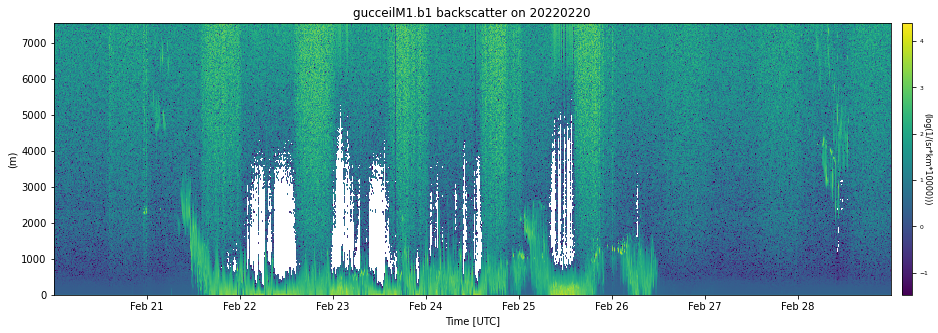

In [8]:
ceil_ds = act.io.armfiles.read_netcdf(os.path.join(outpath,f'ceilometer/{ceil}.2022022*'))
ceil_ds = act.corrections.ceil.correct_ceil(ceil_ds, -9999.)
display = act.plotting.TimeSeriesDisplay(
    ceil_ds, subplot_shape=(1, ), figsize=(15, 5))
display.plot('backscatter', subplot_index=(0, ))
display.plot('first_cbh', color='k', subplot_index=(0, ))

In [7]:
sonde_ds = act.io.armfiles.read_netcdf(os.path.join(outpath,f'radiosonde/{radiosonde}.2022022*'))

In [8]:
kappa = 0.286
sonde_ds = sonde_ds.assign(potential_T = (273.15 + sonde_ds.where(sonde_ds['qc_tdry'] == 0)['tdry']) * (1000 / sonde_ds.where(sonde_ds['qc_tdry'] == 0)['pres'])**kappa - 273.15)

In [10]:
sonde_ds['potential_T'].attrs = {'units':'degC'}

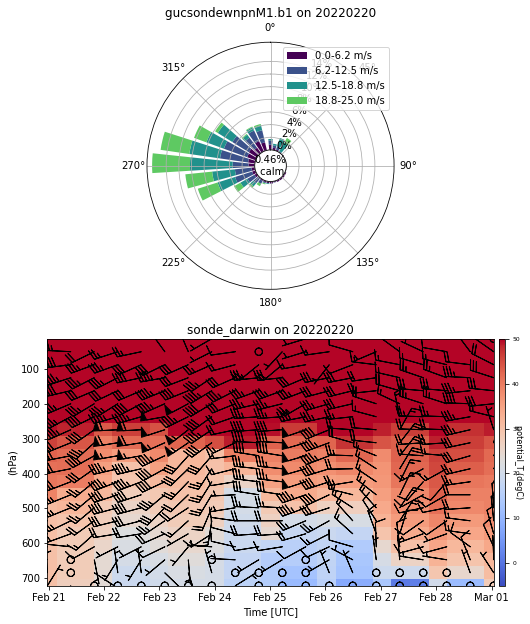

In [13]:
WindDisplay = act.plotting.WindRoseDisplay(sonde_ds, figsize=(8, 10), subplot_shape=(2,))
WindDisplay.plot('deg', 'wspd',
                 spd_bins=np.linspace(0, 25, 5), num_dirs=30,
                 tick_interval=2, subplot_index=(0,))


BarbDisplay = act.plotting.TimeSeriesDisplay(
    {'sonde_darwin': sonde_ds}, figsize=(10, 5))
WindDisplay.put_display_in_subplot(BarbDisplay, subplot_index=(1,))
BarbDisplay.plot_time_height_xsection_from_1d_data('potential_T', 'pres',
                                                   cmap='coolwarm',
                                                   num_time_periods=25,
                                                   vmin=-5,
                                                   vmax=50)
BarbDisplay.plot_barbs_from_spd_dir('deg', 'wspd', 'pres',
                                    num_barbs_x=20)
plt.show()

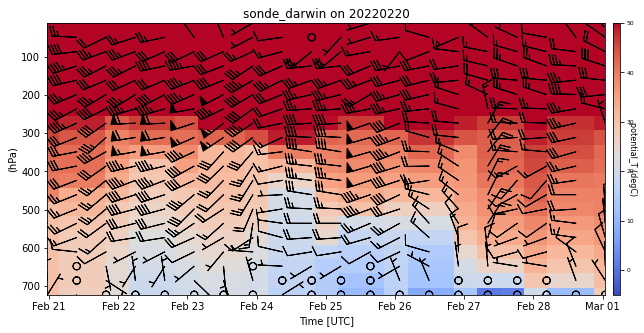

In [31]:
BarbDisplay = act.plotting.TimeSeriesDisplay(
    {'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data('potential_T', 'pres',
                                                   cmap='coolwarm',
                                                   vmin=-5, vmax=50,
                                                   num_time_periods=25)
BarbDisplay.plot_barbs_from_spd_dir('deg', 'wspd', 'pres',
                                    num_barbs_x=20)
plt.show()

In [15]:
met_ds = act.io.armfiles.read_netcdf(os.path.join(outpath,f'radiosonde/{radiosonde}.2022022*'))

In [16]:
sonde_ds_grouped_200 = sonde_ds.groupby_bins(sonde_ds['alt'],200,precision=-1).mean()

In [27]:
# mean lapse rates, 
np.mean((sonde_ds_grouped_200.isel(alt_bins=slice(1,50))['tdry'].diff('alt_bins')*7.69).values)

-6.4038196